<h1>
Custom Estimators
</h1>

<div style="text-align: right;">
<h4>
박주형 연구원의 Optical character recognition; OCR 코드를 참고하였습니다.
</h4>
</div>

---

### Import packages

In [1]:
from IPython.display import Image
import matplotlib.pylab as plt
from matplotlib import rc, font_manager
rc('font', family=font_manager.FontProperties(fname="/home/hufs/다운로드/NanumGothic.ttf").get_name())
import tensorflow as tf
import numpy as np

/home/hufs/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/hufs/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/hufs/anaconda3/lib/python3.6/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 2] No such file or directory: 'uname': 'uname'
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


---

## 1. Custom Estimator란?

- 기본적으로 `tf.contrib.learn`의 미리 만들어진 알고리즘 API를 그대로 사용해 학습시키고, loss를 구하고, 평가할 수 있다.    

- 그러나 목적에 맞게 변형, 보완하고 싶을 때나 다른 종류의 알고리즘을 사용하고 싶을 때는 미리 만들어진 API 보다는 직접 만드는 것이 편하다.    

- 이 때 사용하는 **tf.estimator.Estimator**는 high-level Estimator API를 통해 자신만의 알고리즘을 쉽게 구현할 수 있는 도구이다.     

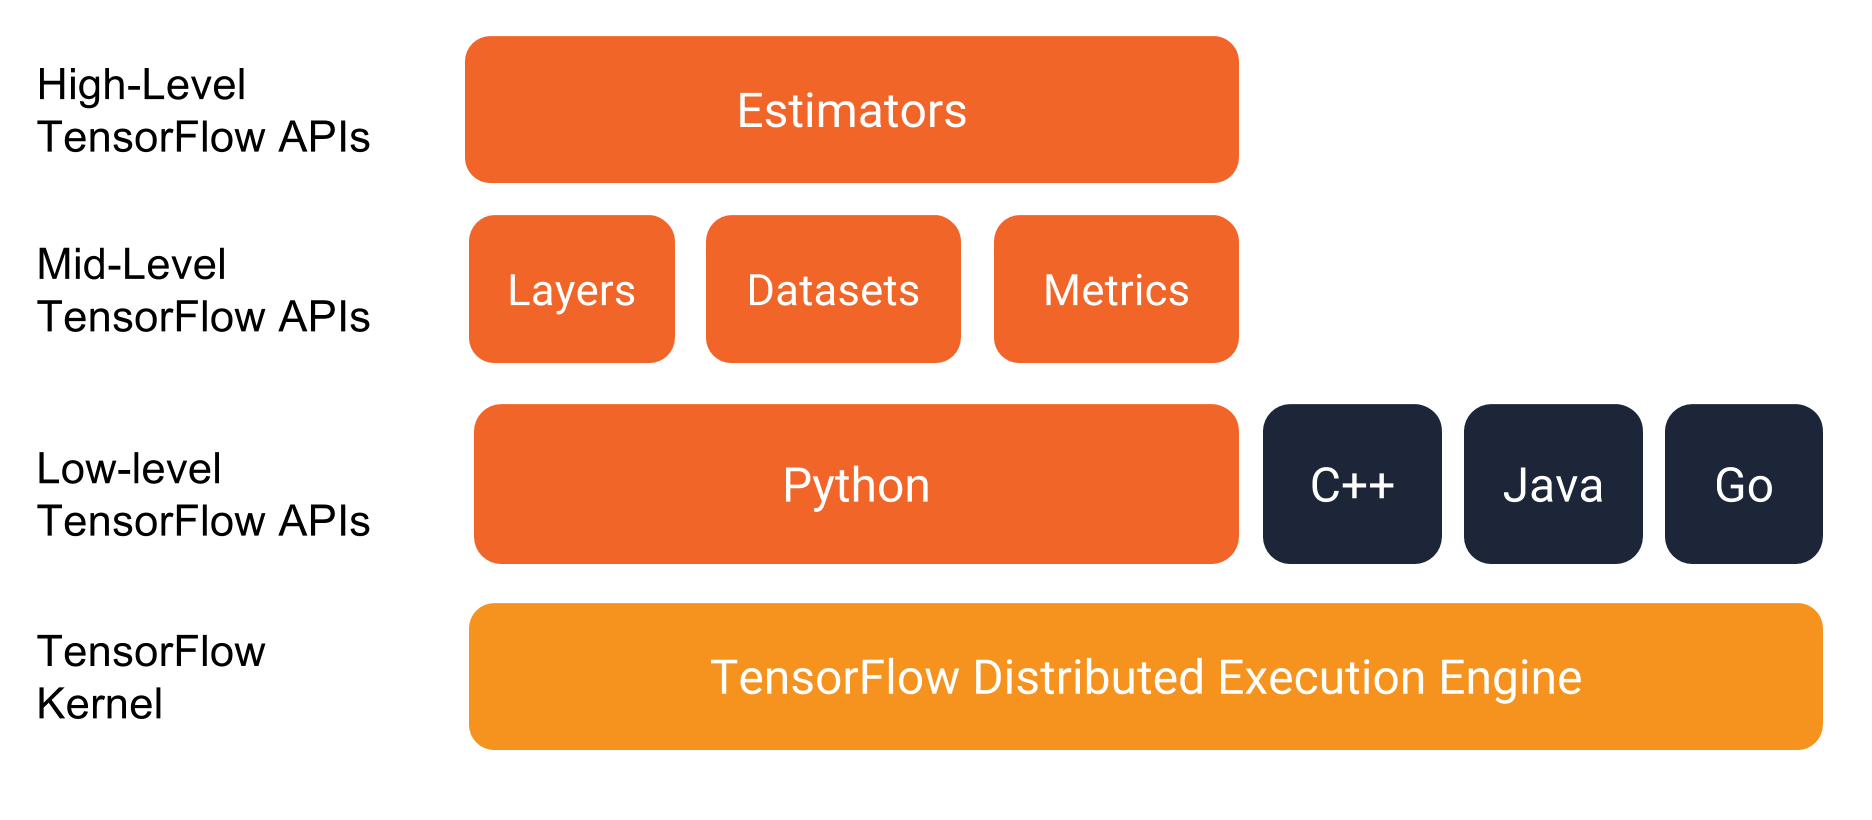

In [2]:
Image(filename='/home/hufs/다운로드/tensorflow_programming_environment.png')

---

## 2. Create a Custom Estimator

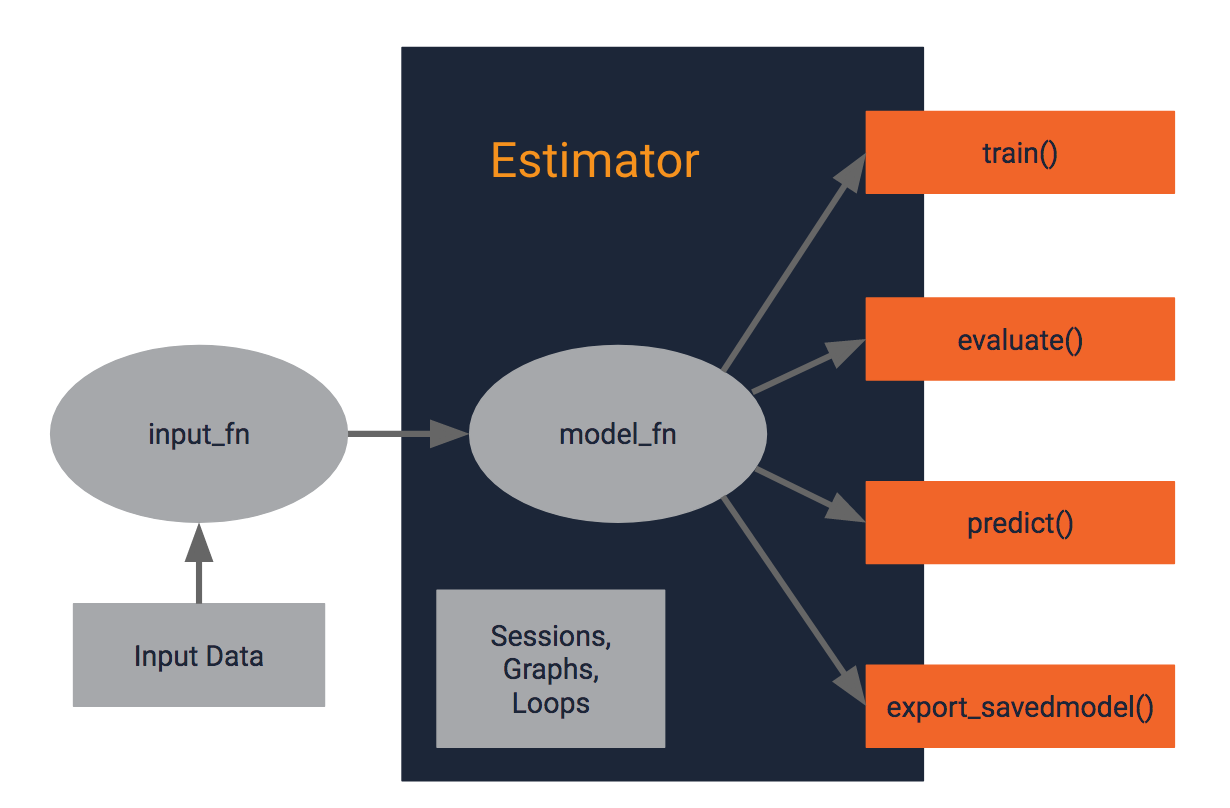

In [3]:
Image(filename='/home/hufs/다운로드/estimator-apis.png')

## Estimator?
Estimator는 model_fn에서 작성한 모델을 포함하는 객체이다.    
주어진 input data와 파라미터들, 훈련,평가,예측에 필요한 연산들을 반환한다. 

In [ ]:
classifier = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               config=run_config,
                               model_dir="./CIFAR10_model/")

* **model_fn** : 함수의 이름. 이 함수에는 어떻게 학습을 할 것인지, loss는 어떻게 구할 것인지, 평가는 어떻게 할 것인지 등에 대한 알고리즘 로직이 구현이 되어 있어야 한다.     
 
 
* **params** : 초기에 model_fn에 전달해야 하는 파라미터들의 정보. 이 예제에서는 간단하게 learning_rate 만 파라미터로 전달해줄 것이다. 이 params를 이용해서 learning_rate 뿐만아니라 dropout이나 lambda 같은 정보들을 전달해 주도록 사용하면 된다.     


* **config** : 실행환경에 대한 정보를 포함하고 있는 RunConfig 객체로 전달된다. 체크포인트와 관련된 것들을 조정하는데 사용된다.      
   
   
* **model_dir** : 모든 output 결과(checkpoints, event files, etc.)는 model_dir에 저장된다.

---

### Data load
CIFAR-10 데이터를 불러온다.

In [4]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


In [5]:
img_size = 32  #  CIFAR-10 이미지 사이즈 : 32x32
num_channels = 3  # 컬러이미지, RGB 
num_classes = len(np.unique(y_train)) # 10 classes

---

* Images

In [6]:
img_shape = (img_size, img_size, num_channels)

def plot_images(images):
    assert len(images) == 25
    fig, axes = plt.subplots(5,5)
    
    for i, ax in enumerate(axes.flat):
        ax.set_axis_off()
        ax.imshow(images[i:i+1][0].reshape(img_shape))
        
    plt.show()

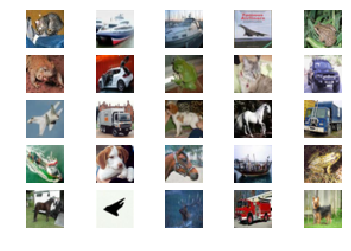

In [7]:
plot_images(images=x_test[:25])

* classes (labels)   
0 : airplane  
1 : automobile  
2 : bird  
3 : cat  
4 : deer  
5 : dog  
6 : frog  
7 : horse  
8 : ship  
9 : truck  

---

CIFAR-10 이미지들은 0~255 사이의 정수로 구성되어 있으므로 0~1사이의 실수로 바꿔준다.

In [8]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

y_train = y_train.reshape([-1])   
y_test = y_test.reshape([-1])
y_train = y_train.astype('Int32')
y_test = y_test.astype('Int32')

/home/hufs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/home/hufs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  import sys


---

## Write an Input Function
사용할 데이터를 불러오는 함수를 직접 지정한다. 

In [9]:
train_input_fn =tf.estimator.inputs.numpy_input_fn(
                                                                            x={"x" : np.array(x_train)},
                                                                            y=np.array(y_train),
                                                                            num_epochs=None,
                                                                            shuffle=True)

In [10]:
test_input_fn =tf.estimator.inputs.numpy_input_fn(
                                                                            x={"x" : np.array(x_test)},
                                                                            y=np.array(y_test),
                                                                            num_epochs=1,
                                                                            shuffle=False)

---

## Build the model
### [VGG Convolutional Neural Network](https://github.com/Park-Ju-hyeong/ConvNet/blob/master/VGG.md)

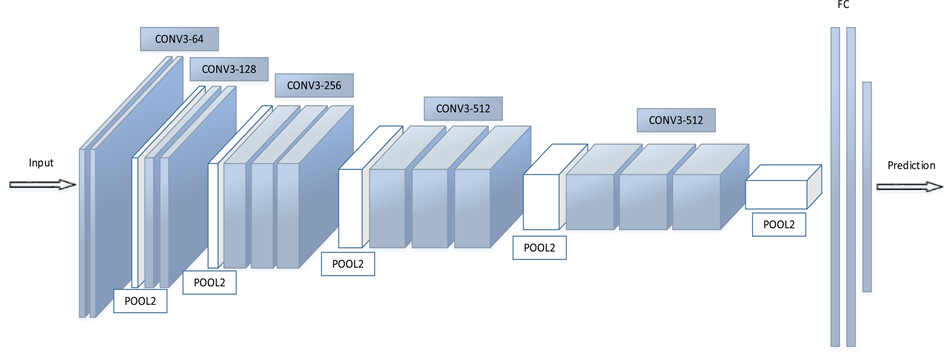

In [5]:
Image(filename='4-7800353x6.png')

---

### model 1

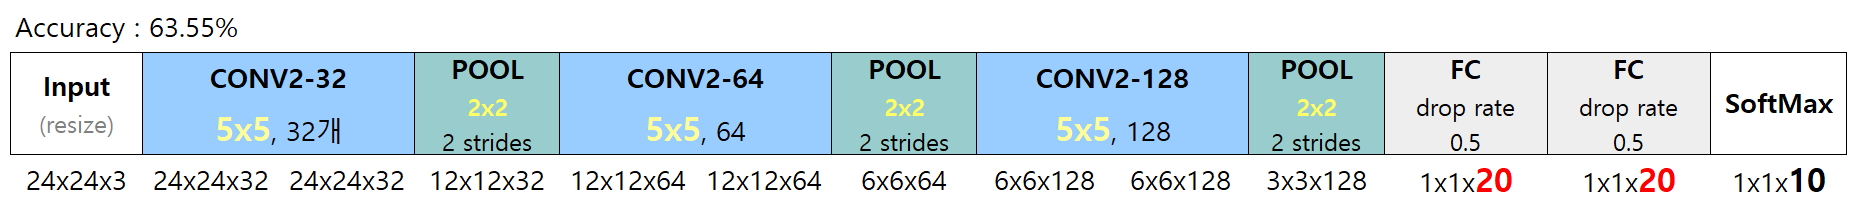

In [2]:
Image(filename='1.png')

In [11]:
def conv2d( X, name, num_filters) :
    return tf.layers.conv2d( inputs=X, name=name, filters = num_filters, 
                                        kernel_size = 5,  # 5x5
                                        padding = 'SAME', 
                                        activation = tf.nn.elu,
                                        reuse=tf.AUTO_REUSE)

In [12]:
def mp2d(X) :
    return tf.layers.max_pooling2d(inputs=X, 
                                                  pool_size = 2, #2x2
                                                  strides =2)

In [13]:
def dense(X, name, node, activation) : 
    return tf.layers.dense(inputs=X , name=name, units=node, 
                                   activation = tf.nn.elu, reuse=tf.AUTO_REUSE)

In [14]:
def dropout(X, drop_rate, training):
    return tf.layers.dropout(inputs=X, rate= drop_rate, training=training)

In [15]:
def vgg(X, training):
    net = tf.reshape(X, [-1,img_size, img_size, num_channels]) 
    net = tf.image.resize_image_with_crop_or_pad(net, 24,24)  # 32x32에서 24x24로 resize(crop)
    
    net = conv2d(net, 'C1', 32)
    net = conv2d(net, 'C2', 32)
    net = mp2d(net)   # 12
    
    net = conv2d(net, 'C3', 64) 
    net = conv2d(net, 'C4', 64)
    net = mp2d(net) # 6
    
    net = conv2d(net, 'C5', 128)   
    net = conv2d(net, 'C6', 128)
    net = mp2d(net) # 3

    net = tf.contrib.layers.flatten(net)
    
    fc = dense(net, 'FC1', 20, tf.nn.elu)   
    fc = dropout(fc, 0.5, training=training)  # drop_rate=0.5
    fc = dense(fc, 'FC2', 20, tf.nn.elu)     
    fc = dropout(fc, 0.5, training=training)  
    
    fc = dense(fc, 'SoftMax', num_classes, None)
    
    return fc

---

## Write a model function     
**model_fn**의 기본 구성은 다음과 같다. 

In [ ]:
def model_fn( features,  labels,  mode,  params) :
    #1. Configure the model via TensorFlow operations (학습 모델 구성)
    #2. Define the loss function for training/evaluation (loss function 정의)
    #3. Define the training operation/optimizer (optimizer 정의)
    #4. Generate predictions (예측결과값 생성)
    return spec

* **features** : 학습을 하기 위해서 사용될 feature 데이터 (from input_fn)
* **labels** : label 데이터가 포함되어 있는 Tensor 값 (from input_fn)
* **mode** : modekeys 값 중에 하나 (tf.estimator.ModeKeys, 아래 표 참고)    
* **params** : 앞에서 Estimator를 생성할 때 주어지는 params가 전달됨

| Estimator method | Estimator Mode   |
|------------------|------------------|
| train()          | ModeKeys.TRAIN   |
| evaluate()       | ModeKeys.EVAL    |
| predict()        | ModeKeys.PREDICT |


In [16]:
def model_fn(features, labels, mode, params) : 
    
    x = features["x"]
    
    net_train = vgg( x, training = True )
    net_test = vgg( x, training = False)
    
    y_pred = tf.nn.softmax(logits = net_test ) 
    y_pred_class = tf.argmax(y_pred, axis = 1)
    
    ##  예측
    if mode == tf.estimator.ModeKeys.PREDICT: 
        spec = tf.estimator.EstimatorSpec(mode=mode, predictions=y_pred_class) # Compute predictions
   
    ## 학습 및 평가
    else :  
        
    # Tensor값을 Target과 비교하기 위하여 softmax를 이용해 텐서를 각 class에 속할 확률로 바꾼다.   
    #  이 확률값을 실제 Target 값과 비교한 후 cross-entropy를 이용하여 그 차이를 계산하고, 
    #  차이를 줄이는 방향으로 가중치 필터를 갱신, 즉 최적화한다.

        cross_entropy= tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits = net_train)  #소프트맥스와 교차 엔트로피를 한 번에 구하는 함수
        loss = tf.reduce_mean(cross_entropy) # Compute loss
        tf.summary.scalar("loss", loss) 

        optimizer = tf.train.AdamOptimizer(learning_rate = params["learning_rate"])  # 최적화(minimized loss값을 찾는 optimizer를 지정해준다.)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step()) # 이것을 train_op로 넘겨주면 실제 학습을 수행하는 operation이 된다.

        acc = tf.metrics.accuracy(labels, y_pred_class)  # Compute evaluation metrics
        
        logging_hook = tf.train.LoggingTensorHook(
            {
                "my_loss" : loss,
                "my_step" : tf.train.get_global_step(),
            },
            every_n_iter=10000)
        
        summary_hook = tf.train.SummarySaverHook(
            save_secs=60,
            output_dir='./logs/tf2',
            summary_op=tf.summary.merge_all())
            
        spec = tf.estimator.EstimatorSpec(  
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops={"accuracy": acc},
            training_hooks=[logging_hook, summary_hook]
        )
        
    return spec

In [17]:
params = {
    "learning_rate": 5e-5   # 학습률 조정 
}

---

In [18]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [19]:
run_config = tf.estimator.RunConfig(session_config=config,
                                    save_summary_steps=100,
                                    keep_checkpoint_max=3,
                                    keep_checkpoint_every_n_hours=1,
                                    log_step_count_steps=10000)

---

## Estimator 객체 생성

In [20]:
model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               config=run_config,
                               model_dir="./CIFAR10_model1/")

INFO:tensorflow:Using config: {'_model_dir': './CIFAR10_model1/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 1, '_log_step_count_steps': 10000, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ffa3c341518>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


---

## Train, evaluate and predict

In [21]:
model.train(input_fn=train_input_fn, steps=10000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./CIFAR10_model1/model.ckpt-1
INFO:tensorflow:Saving checkpoints for 2 into ./CIFAR10_model1/model.ckpt.
INFO:tensorflow:loss = 2.3221335, step = 2
INFO:tensorflow:my_loss = 2.3221335, my_step = 2
INFO:tensorflow:loss = 2.207545, step = 102 (92.300 sec)
INFO:tensorflow:loss = 2.0326262, step = 202 (88.183 sec)
INFO:tensorflow:loss = 2.1243482, step = 302 (89.760 sec)
INFO:tensorflow:loss = 2.082467, step = 402 (88.025 sec)
INFO:tensorflow:loss = 2.115354, step = 502 (88.048 sec)
INFO:tensorflow:loss = 2.0629435, step = 602 (88.049 sec)
INFO:tensorflow:Saving checkpoints for 677 into ./CIFAR10_model1/model.ckpt.
INFO:tensorflow:loss = 2.047799, step = 702 (88.157 sec)
INFO:tensorflow:loss = 1.9747751, step = 802 (88.135 sec)
INFO:tensorflow:loss = 1.9741488, step = 902 (88.202 sec)
INFO:tensorflow:loss = 1.9441292, step = 1002 (88.059 sec)
INFO:tensorflow:loss = 1.9736469, step = 1102 (88.299 sec)
INFO

---

In [22]:
result = model.evaluate(input_fn=test_input_fn) 

INFO:tensorflow:Starting evaluation at 2018-02-13-04:06:13
INFO:tensorflow:Restoring parameters from ./CIFAR10_model1/model.ckpt-10001
INFO:tensorflow:Finished evaluation at 2018-02-13-04:06:58
INFO:tensorflow:Saving dict for global step 10001: accuracy = 0.6355, global_step = 10001, loss = 1.3870903


In [23]:
result

{'accuracy': 0.6355, 'global_step': 10001, 'loss': 1.3870903}

### > model 1 accuracy : 

In [24]:
print("Classification accuracy: {0:.5%}".format(result["accuracy"]))

Classification accuracy: 63.55000%


---

In [25]:
predictions = model.predict(input_fn=test_input_fn)
cls_pred = np.array(list(predictions))
cls_pred

INFO:tensorflow:Restoring parameters from ./CIFAR10_model1/model.ckpt-10001


array([3, 8, 1, ..., 5, 0, 7])

---

### model 2

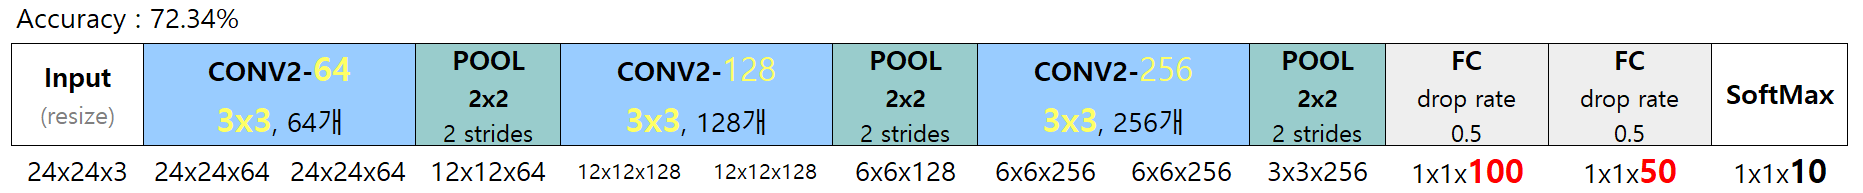

In [3]:
Image(filename='2.png')

In [26]:
def conv2d( X, name, num_filters) :
    return tf.layers.conv2d( inputs=X, name=name, filters = num_filters, 
                                        kernel_size = 3,  # 3x3
                                        padding = 'SAME', 
                                        activation = tf.nn.elu,
                                        reuse=tf.AUTO_REUSE)

In [27]:
def mp2d(X) :
    return tf.layers.max_pooling2d(inputs=X, 
                                                  pool_size = 2,  # 2x2
                                                  strides =2)

In [28]:
def dense(X, name, node, activation) : 
    return tf.layers.dense(inputs=X , name=name, units=node, 
                                   activation = tf.nn.elu, reuse=tf.AUTO_REUSE)

In [29]:
def dropout(X, drop_rate, training):
    return tf.layers.dropout(inputs=X, rate= drop_rate, training=training)

In [30]:
def vgg(X, training):
    net = tf.reshape(X, [-1,img_size, img_size, num_channels]) 
    net = tf.image.resize_image_with_crop_or_pad(net, 24,24)
    
    net = conv2d(net, 'C1', 64)  
    net = conv2d(net, 'C2', 64)
    net = mp2d(net)   # 12
    
    net = conv2d(net, 'C3', 128) 
    net = conv2d(net, 'C4', 128)
    net = mp2d(net) # 6
    
    net = conv2d(net, 'C5', 256)   
    net = conv2d(net, 'C6', 256)
    net = mp2d(net) # 3
    
    net = tf.contrib.layers.flatten(net)
    
    fc = dense(net, 'FC1', 100, tf.nn.elu)   
    fc = dropout(fc, 0.5, training=training)  
    fc = dense(fc, 'FC2', 50, tf.nn.elu)   
    fc = dropout(fc, 0.5, training=training)  
    
    fc = dense(fc, 'SoftMax', num_classes, None)
    
    return fc

---

In [31]:
def model_fn(features, labels, mode, params) : 
    
    x = features["x"]
    
    net_train = vgg( x, training = True )
    net_test = vgg( x, training = False)
    
    y_pred = tf.nn.softmax(logits = net_test ) 
    y_pred_class = tf.argmax(y_pred, axis = 1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        spec = tf.estimator.EstimatorSpec(mode=mode, predictions=y_pred_class)
        
    else :
        cross_entropy= tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits = net_train)
        loss = tf.reduce_mean(cross_entropy)
        tf.summary.scalar("loss", loss)  
        
        
        optimizer = tf.train.AdamOptimizer(learning_rate = params["learning_rate"])
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        
        acc = tf.metrics.accuracy(labels, y_pred_class)
        
        logging_hook = tf.train.LoggingTensorHook(
            {
                "my_loss" : loss,
                "my_step" : tf.train.get_global_step(),
            },
            every_n_iter=10000)
        
        summary_hook = tf.train.SummarySaverHook(
            save_secs=60,
            output_dir='./logs/tf2',
            summary_op=tf.summary.merge_all())
            
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops={"accuracy": acc},
            training_hooks=[logging_hook, summary_hook]
        )
        
    return spec

In [32]:
params = {
    "learning_rate": 5e-5  
}

---

In [33]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [34]:
run_config = tf.estimator.RunConfig(session_config=config,
                                    save_summary_steps=100,
                                    keep_checkpoint_max=3,
                                    keep_checkpoint_every_n_hours=1,
                                    log_step_count_steps=10000)

---

In [35]:
model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               config=run_config,
                               model_dir="./CIFAR10_model2/")

INFO:tensorflow:Using config: {'_model_dir': './CIFAR10_model2/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 1, '_log_step_count_steps': 10000, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff9a40e0748>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


---

In [36]:
model.train(input_fn=train_input_fn, steps=10000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./CIFAR10_model2/model.ckpt.
INFO:tensorflow:loss = 2.3634372, step = 1
INFO:tensorflow:my_loss = 2.3634372, my_step = 1
INFO:tensorflow:loss = 2.0521646, step = 101 (112.329 sec)
INFO:tensorflow:loss = 2.0877404, step = 201 (113.675 sec)
INFO:tensorflow:loss = 1.9418459, step = 301 (115.287 sec)
INFO:tensorflow:loss = 1.76365, step = 401 (112.456 sec)
INFO:tensorflow:loss = 1.7277154, step = 501 (114.507 sec)
INFO:tensorflow:Saving checkpoints for 528 into ./CIFAR10_model2/model.ckpt.
INFO:tensorflow:loss = 1.8099587, step = 601 (114.855 sec)
INFO:tensorflow:loss = 1.6961784, step = 701 (120.516 sec)
INFO:tensorflow:loss = 1.8036631, step = 801 (114.961 sec)
INFO:tensorflow:loss = 1.6866884, step = 901 (113.215 sec)
INFO:tensorflow:loss = 1.596157, step = 1001 (115.722 sec)
INFO:tensorflow:Saving checkpoints for 1048 into ./CIFAR10_model2/model.ckpt.
INFO:tensorflow:loss = 1.4626683, step = 1101 

---

In [37]:
result = model.evaluate(input_fn=test_input_fn) 
result

INFO:tensorflow:Starting evaluation at 2018-02-13-07:17:15
INFO:tensorflow:Restoring parameters from ./CIFAR10_model2/model.ckpt-10000
INFO:tensorflow:Finished evaluation at 2018-02-13-07:18:11
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.7234, global_step = 10000, loss = 1.0248022


{'accuracy': 0.7234, 'global_step': 10000, 'loss': 1.0248022}

### > model 2 accuracy : 

In [38]:
print("Classification accuracy: {0:.5%}".format(result["accuracy"]))

Classification accuracy: 72.34000%


---

In [39]:
predictions = model.predict(input_fn=test_input_fn)

In [40]:
cls_pred = np.array(list(predictions))
cls_pred

INFO:tensorflow:Restoring parameters from ./CIFAR10_model2/model.ckpt-10000


array([3, 8, 8, ..., 5, 4, 7])

---

### model 3

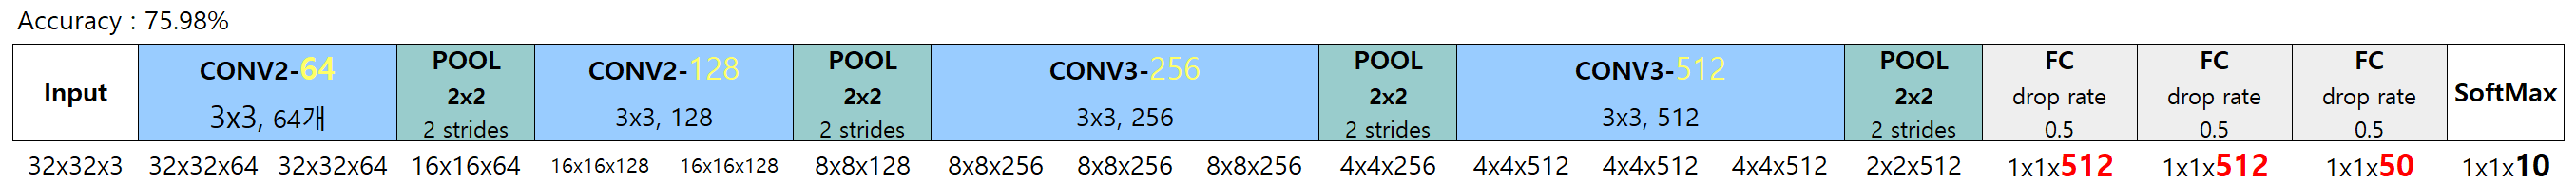

In [4]:
Image(filename='3.png')

In [55]:
def conv2d( X, name, num_filters) :
    return tf.layers.conv2d( inputs=X, name=name, filters = num_filters, 
                                        kernel_size = 3,  # 3x3
                                        padding = 'SAME', 
                                        activation = tf.nn.elu,
                                        reuse=tf.AUTO_REUSE)

In [56]:
def mp2d(X) :
    return tf.layers.max_pooling2d(inputs=X, 
                                                  pool_size =2, #2x2
                                                  strides =2)

In [57]:
def dense(X, name, node, activation) : 
    return tf.layers.dense(inputs=X , name=name, units=node, 
                                   activation = tf.nn.elu, reuse=tf.AUTO_REUSE)

In [58]:
def dropout(X, drop_rate, training):
    return tf.layers.dropout(inputs=X, rate= drop_rate, training=training)

In [59]:
def vgg(X, training):
    net = tf.reshape(X, [-1,img_size, img_size, num_channels]) 
       ## net = tf.image.resize_image_with_crop_or_pad(net, 24,24)
    
    net = conv2d(net, 'C1', 64)  
    net = conv2d(net, 'C2', 64)
    net = mp2d(net)   # 16
    
    net = conv2d(net, 'C3', 128) 
    net = conv2d(net, 'C4', 128)
    net = mp2d(net) # 8
    
    net = conv2d(net, 'C5', 256)   
    net = conv2d(net, 'C6', 256)
    net = conv2d(net, 'C7', 256)
    net = mp2d(net) # 4
   
    net = conv2d(net, 'C8', 512)   
    net = conv2d(net, 'C9', 512)
    net = conv2d(net, 'C10', 512)
    net = mp2d(net) # 2
    
    net = tf.contrib.layers.flatten(net)
    
    fc = dense(net, 'FC1', 512, tf.nn.elu)   
    fc = dropout(fc, 0.5, training=training)  
    fc = dense(net, 'FC2', 512, tf.nn.elu)   
    fc = dropout(fc, 0.5, training=training)  
    fc = dense(fc, 'FC3', 50, tf.nn.elu)   
    fc = dropout(fc, 0.5, training=training)  
    
    fc = dense(fc, 'SoftMax', num_classes, None) #10
    
    return fc

In [60]:
def model_fn(features, labels, mode, params) : 
    
    x = features["x"]
    
    net_train = vgg( x, training = True )
    net_test = vgg( x, training = False)
    
    y_pred = tf.nn.softmax(logits = net_test ) 
    y_pred_class = tf.argmax(y_pred, axis = 1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        spec = tf.estimator.EstimatorSpec(mode=mode, predictions=y_pred_class)
        
    else :
        cross_entropy= tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits = net_train)
        loss = tf.reduce_mean(cross_entropy)
        tf.summary.scalar("loss", loss)  
        
        
        optimizer = tf.train.AdamOptimizer(learning_rate = params["learning_rate"])
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        
        acc = tf.metrics.accuracy(labels, y_pred_class)
        
        logging_hook = tf.train.LoggingTensorHook(
            {
                "my_loss" : loss,
                "my_step" : tf.train.get_global_step(),
            },
            every_n_iter=10000)
        
        summary_hook = tf.train.SummarySaverHook(
            save_secs=60,
            output_dir='./logs/tf2',
            summary_op=tf.summary.merge_all())
            
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops={"accuracy": acc},
            training_hooks=[logging_hook, summary_hook]
        )
        
    return spec

In [61]:
params = {
    "learning_rate": 5e-5 
}

In [62]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [63]:
run_config = tf.estimator.RunConfig(session_config=config,
                                    save_summary_steps=100,
                                    keep_checkpoint_max=3,
                                    keep_checkpoint_every_n_hours=1,
                                    log_step_count_steps=10000)

---

In [64]:
model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               config=run_config,
                               model_dir="./CIFAR10_VGGNet/")

INFO:tensorflow:Using config: {'_model_dir': './CIFAR10_VGGNet/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
, '_keep_checkpoint_max': 3, '_keep_checkpoint_every_n_hours': 1, '_log_step_count_steps': 10000, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff9a569a048>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [65]:
model.train(input_fn=train_input_fn, steps=10000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./CIFAR10_VGGNet/model.ckpt.
INFO:tensorflow:loss = 2.301439, step = 1
INFO:tensorflow:my_loss = 2.301439, my_step = 1
INFO:tensorflow:loss = 1.8394759, step = 101 (378.834 sec)
INFO:tensorflow:Saving checkpoints for 159 into ./CIFAR10_VGGNet/model.ckpt.
INFO:tensorflow:loss = 1.6991482, step = 201 (392.375 sec)
INFO:tensorflow:loss = 1.5248871, step = 301 (392.355 sec)
INFO:tensorflow:Saving checkpoints for 311 into ./CIFAR10_VGGNet/model.ckpt.
INFO:tensorflow:loss = 1.4775133, step = 401 (401.837 sec)
INFO:tensorflow:Saving checkpoints for 462 into ./CIFAR10_VGGNet/model.ckpt.
INFO:tensorflow:loss = 1.5038452, step = 501 (399.994 sec)
INFO:tensorflow:loss = 1.3741487, step = 601 (398.489 sec)
INFO:tensorflow:Saving checkpoints for 613 into ./CIFAR10_VGGNet/model.ckpt.
INFO:tensorflow:loss = 1.4495692, step = 701 (397.873 sec)
INFO:tensorflow:Saving checkpoints for 765 into ./CIFAR10_VGGNet/model

INFO:tensorflow:loss = 0.11527595, step = 7301 (387.133 sec)
INFO:tensorflow:loss = 0.14998494, step = 7401 (386.407 sec)
INFO:tensorflow:Saving checkpoints for 7431 into ./CIFAR10_VGGNet/model.ckpt.
INFO:tensorflow:loss = 0.0835911, step = 7501 (384.921 sec)
INFO:tensorflow:Saving checkpoints for 7587 into ./CIFAR10_VGGNet/model.ckpt.
INFO:tensorflow:loss = 0.23053418, step = 7601 (384.911 sec)
INFO:tensorflow:loss = 0.08314434, step = 7701 (385.964 sec)
INFO:tensorflow:Saving checkpoints for 7743 into ./CIFAR10_VGGNet/model.ckpt.
INFO:tensorflow:loss = 0.087029286, step = 7801 (382.931 sec)
INFO:tensorflow:Saving checkpoints for 7900 into ./CIFAR10_VGGNet/model.ckpt.
INFO:tensorflow:loss = 0.118917525, step = 7901 (384.290 sec)
INFO:tensorflow:loss = 0.19752006, step = 8001 (383.049 sec)
INFO:tensorflow:Saving checkpoints for 8057 into ./CIFAR10_VGGNet/model.ckpt.
INFO:tensorflow:loss = 0.111882195, step = 8101 (383.134 sec)
INFO:tensorflow:loss = 0.09411581, step = 8201 (383.794 sec

In [66]:
result = model.evaluate(input_fn=test_input_fn) 

INFO:tensorflow:Starting evaluation at 2018-02-13-18:25:15
INFO:tensorflow:Restoring parameters from ./CIFAR10_VGGNet/model.ckpt-10000
INFO:tensorflow:Finished evaluation at 2018-02-13-18:26:36
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.7598, global_step = 10000, loss = 1.3085787


In [67]:
result

{'accuracy': 0.7598, 'global_step': 10000, 'loss': 1.3085787}

### >> model 3 accuracy :

In [68]:
print("Classification accuracy: {0:.5%}".format(result["accuracy"]))

Classification accuracy: 75.98000%


---

In [69]:
predictions = model.predict(input_fn=test_input_fn)
cls_pred = np.array(list(predictions))
cls_pred

INFO:tensorflow:Restoring parameters from ./CIFAR10_VGGNet/model.ckpt-10000


array([3, 8, 8, ..., 5, 1, 7])